<font color=purple > _**Emily Nordhoff - 2022**_ </font>

# Unsupervised Machine Learning

This script contains a k-means clustering model using pitch and hit variables from all balls in play in the MLB 
2021 season. Data was gathered from BaseballSavant.com.

### Contents

    1. Importing data and libraries
    2. Data prep for clustering
        2.1 Subset data
        2.2 Check for missing values
        2.3 Scale variables
    3. Elbow technique
    4. K-means clustering
    5. Visualizations and observations
    6. K-means clustering part II

## 1. Importing data and libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
path = r'/Users/Emily/Documents/CF Data Analysis Program/Immersion 6/Hits Analysis/'

In [3]:
df = pd.read_pickle(os.path.join(path,'02 data','prepared data','bip_ballparks_merged_gis.pkl'))

In [4]:
df.head()

,pitch_type,game_date,release_speed,player_name,batter,pitcher,events,zone,stand,p_throws,...,batter_home_away,contact,runner_1b,runner_2b,runner_3b,scoring_play,Latitude,Longitude,park_city,park_state
0,FC,2021-04-30,82.7,"Altuve, Jose",514888,642232,field_out,4.0,R,L,...,away,Under,NaN,NaN,NaN,False,27.768284,-82.653961,St. Petersburg,Florida
1,FC,2021-04-30,82.4,"Maldonado, Martín",455117,642232,field_out,8.0,R,L,...,away,Flare/Burner,NaN,NaN,NaN,False,27.768284,-82.653961,St. Petersburg,Florida
2,CH,2021-04-30,83.8,"Kiermaier, Kevin",595281,621121,field_out,5.0,L,R,...,home,Under,NaN,NaN,NaN,False,27.768284,-82.653961,St. Petersburg,Florida
3,FC,2021-04-30,82.7,"Straw, Myles",664702,642232,field_out,13.0,R,L,...,away,Under,NaN,NaN,NaN,False,27.768284,-82.653961,St. Petersburg,Florida
4,SL,2021-04-30,88.0,"Díaz, Yandy",650490,621121,field_out,8.0,R,R,...,home,Barrel,NaN,1.0,NaN,False,27.768284,-82.653961,St. Petersburg,Florida


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121707 entries, 0 to 121706
Data columns (total 57 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   pitch_type             121654 non-null  object 
 1   game_date              121707 non-null  object 
 2   release_speed          121653 non-null  float64
 3   player_name            121707 non-null  object 
 4   batter                 121707 non-null  int64  
 5   pitcher                121707 non-null  int64  
 6   events                 121707 non-null  object 
 7   zone                   121654 non-null  float64
 8   stand                  121707 non-null  object 
 9   p_throws               121707 non-null  object 
 10  home_team              121707 non-null  object 
 11  away_team              121707 non-null  object 
 12  hit_location           115340 non-null  float64
 13  bb_type                121703 non-null  object 
 14  balls                  121707 non-nu

## 2. Data prep for clustering model

### 2.1 Subset data

In [6]:
# identify all the useful numeric columns
# might have to slim this down to a smaller number of columns
# (or maybe perform PCA?!?!?)

columns = ['release_speed',
#          'zone',
#          'balls',
#          'strikes',
          'pfx_x',
          'pfx_z',
          'plate_x',
          'plate_z',
          'vx0',
          'vy0',
          'vz0',
          'ax',
          'ay',
          'az',
          'hit_distance_sc',
          'launch_speed',
          'launch_angle']

In [7]:
# subset for just the home runs

df2 = df[columns].loc[df['events'] == 'home_run']

### 2.2 Check for (and handle) missing values

In [8]:
df2.isnull().sum()

release_speed       9
pfx_x               9
pfx_z               9
plate_x             9
plate_z             9
vx0                 9
vy0                 9
vz0                 9
ax                  9
ay                  9
az                  9
hit_distance_sc    11
launch_speed       11
launch_angle       11
dtype: int64

In [9]:
# choose one of the variables with the highest number of missing values and eliminate those records

df2 = df2.loc[df2['hit_distance_sc'].isnull() == False]

In [10]:
# check to make sure there are no more 

df2.isnull().sum()

release_speed      0
pfx_x              0
pfx_z              0
plate_x            0
plate_z            0
vx0                0
vy0                0
vz0                0
ax                 0
ay                 0
az                 0
hit_distance_sc    0
launch_speed       0
launch_angle       0
dtype: int64

In [11]:
df2.shape

(5933, 14)

### 2.3 Scaling

In [12]:
# create scaler object using StandardScaler from sklearn.preprocessing
# StandardScaler assumes data is normally distributed and scales with a distribution
# around 0 and standard deviation of 1. Scaling happens independently with each variable.

scaler = StandardScaler()

In [13]:
# create new df with scaled data

df_scaled = pd.DataFrame(scaler.fit_transform(df2), columns=columns)
df_scaled.head()

,release_speed,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,hit_distance_sc,launch_speed,launch_angle
0,-1.977271,1.869974,-0.073341,0.393492,-0.980440,-1.779509,2.009087,0.992534,1.536201,-1.031100,-0.466783,0.158925,-0.323204,-0.326891
1,-0.052922,0.312912,0.071211,1.730794,-0.394123,0.447199,0.034001,0.284120,0.266127,0.067151,-0.051368,1.162874,1.162340,1.199178
2,0.014012,1.419886,0.114577,0.588009,0.151758,-0.982581,-0.023188,-0.151541,1.446435,0.560572,0.022375,-0.729184,-0.120629,-1.280684
3,0.164613,1.760493,0.432592,1.779424,0.353936,-1.365026,-0.165894,-0.350454,1.832603,0.670064,0.363799,2.514343,1.882604,1.199178
4,1.218822,-1.511771,0.288040,-0.627720,0.273065,0.673307,-1.220753,-0.575880,-1.683211,1.757675,0.441622,0.622286,0.216994,0.054626


In [14]:
# just to compare the original vs. scaled data

df2.head()

,release_speed,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,hit_distance_sc,launch_speed,launch_angle
20,77.1,1.42,0.72,0.16,1.99,-8.067947,-111.990784,-1.318431,13.510652,22.445496,-26.092514,405.0,103.0,27.0
56,88.6,0.14,0.82,0.71,2.28,4.478044,-129.057787,-3.210782,0.625105,26.799068,-22.556280,431.0,109.6,35.0
59,89.0,1.05,0.85,0.24,2.55,-3.577797,-129.551960,-4.374543,12.599927,28.755035,-21.928535,382.0,103.9,22.0
105,89.9,1.33,1.07,0.73,2.65,-5.732619,-130.785103,-4.905889,16.517801,29.189072,-19.022148,466.0,112.8,35.0
137,96.2,-1.36,0.97,-0.26,2.61,5.752009,-139.900294,-5.508058,-19.151922,33.500467,-18.359680,417.0,105.4,29.0


## 3. Elbow technique

In [15]:
# Defines the range of potential clusters in the data.

num_cl = range(1, 10) 

# Defines k-means clusters in the range assigned above.

kmeans = [KMeans(n_clusters=i) for i in num_cl] 

In [16]:
# create a score that represents a rate of variation for each given cluster option

score = [kmeans[i].fit(df_scaled).score(df_scaled) for i in range(len(kmeans))]
score

[-83062.00000000007,
 -60665.12182798128,
 -51457.71014570684,
 -47911.95546891584,
 -45009.498806495554,
 -42796.33125240037,
 -40901.985768982115,
 -39715.9477790169,
 -38789.51408641426]

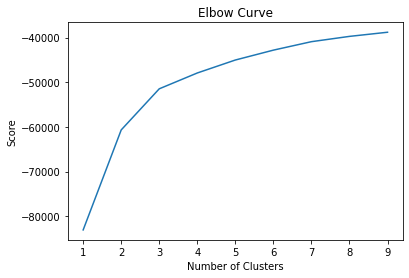

In [17]:
plt.plot(num_cl, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

This elbow curve is not very definitive on the appropriate number of clusters. The change in variation diminishes after 3 clusters, but just 3 might not account for the differences in the data. A few possible reasons: there are too many variables and maybe they should be reduced or more focused, the types of clusters aren't well identified, the data isn't normally distributed, so the incorrect scaler was used. <br> <br> Regardless, I'm going to move forward with the k-means clustering using 3 clusters.

## 4. K-means clustering

In [18]:
kmeans = KMeans(n_clusters = 3) 

In [19]:
kmeans.fit(df_scaled)

KMeans(n_clusters=3)

In [20]:
df_scaled['clusters'] = kmeans.fit_predict(df_scaled)
df2['clusters'] = kmeans.fit_predict(df_scaled)

In [21]:
df2.head()

,release_speed,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,hit_distance_sc,launch_speed,launch_angle,clusters
20,77.1,1.42,0.72,0.16,1.99,-8.067947,-111.990784,-1.318431,13.510652,22.445496,-26.092514,405.0,103.0,27.0,1
56,88.6,0.14,0.82,0.71,2.28,4.478044,-129.057787,-3.210782,0.625105,26.799068,-22.556280,431.0,109.6,35.0,2
59,89.0,1.05,0.85,0.24,2.55,-3.577797,-129.551960,-4.374543,12.599927,28.755035,-21.928535,382.0,103.9,22.0,0
105,89.9,1.33,1.07,0.73,2.65,-5.732619,-130.785103,-4.905889,16.517801,29.189072,-19.022148,466.0,112.8,35.0,0
137,96.2,-1.36,0.97,-0.26,2.61,5.752009,-139.900294,-5.508058,-19.151922,33.500467,-18.359680,417.0,105.4,29.0,2


In [22]:
df2['clusters'].value_counts()

2    2624
1    2135
0    1174
Name: clusters, dtype: int64

## 5. Visualizations and observations

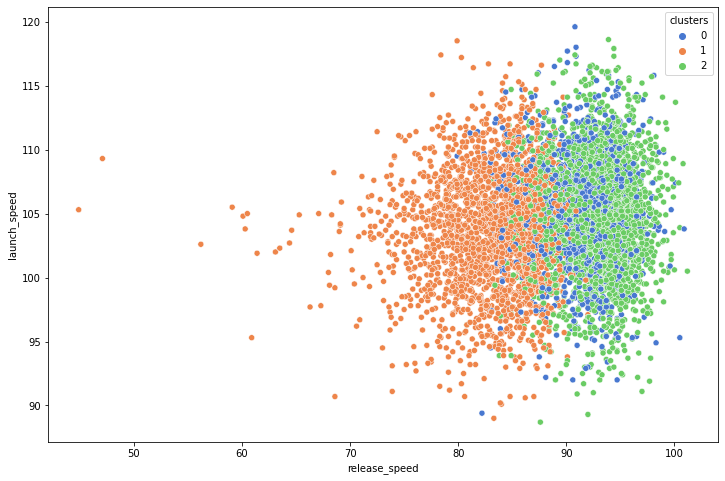

In [23]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df2, x='release_speed', y='launch_speed', hue='clusters', palette='muted')
plt.show()

This scatterplot compares <strong>release speed of the pitch </strong> and <strong>speed of the ball off the bat </strong>. The clustering separates the data largely by speed of the pitch, irrespective of speed of the batted ball. 

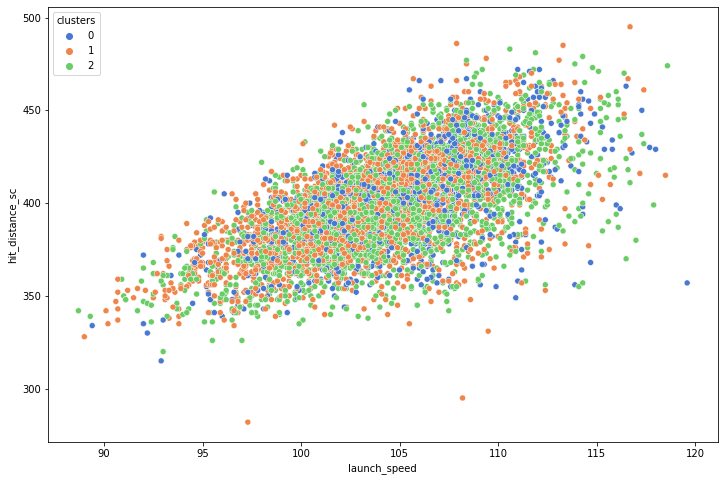

In [24]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df2, x='launch_speed', y='hit_distance_sc', hue='clusters', palette='muted')
plt.show()

This scatterplot compares <strong>speed of the ball off the bat </strong>and the <strong>distance of the hit </strong>. The clustering doesn't yield any information with this plot. 

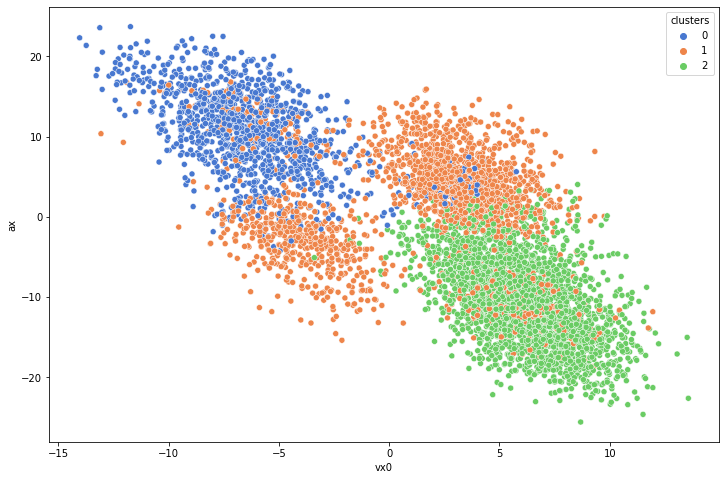

In [25]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df2, x='vx0', y='ax', hue='clusters', palette='muted')
plt.show()

This scatterplot compares <strong>velocity of the pitch in the horizontal plane</strong> (in feet/second) and the <strong>acceleration of the pitch in the same plane</strong> (in ft/second/second). The scatterplot shows a negative relationship (linear-ish) between the two variables. The clustering groups together the pitches that have (absolute value of) high velocity and (absolute value of) and high acceleration while the third group has lower horizontal acceleration or velocity. It's interesting to see that there's a gap where velocity and acceleration are zero (which means no horizontal movement).

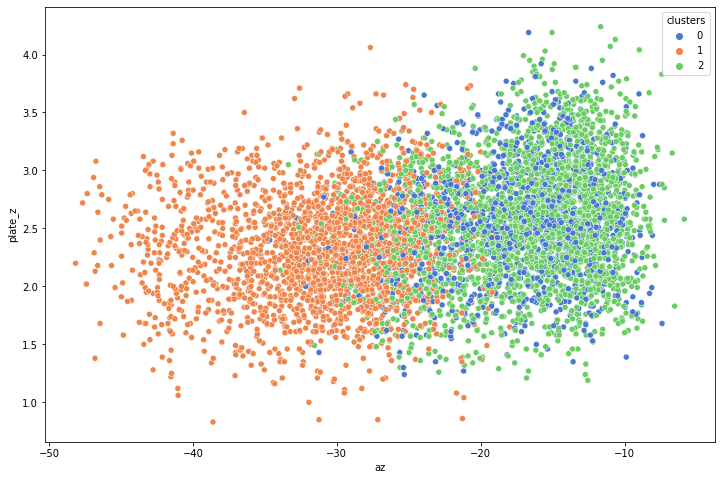

In [26]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df2, y='plate_z', x='az', hue='clusters', palette='muted')
plt.show()

This scatterplot compares <strong>height of the ball when it crosses the plate</strong> (in feet) and the <strong>acceleration of the pitch in the vertical plane</strong> (in ft/second/second). The clustering is mostly due to the change in acceleration and not related to the height of the pitch. Similar to the previous task (6.4) this is another indication that the height of the pitch when it crosses the plate has little correlation to the rest of the stats of a home run.

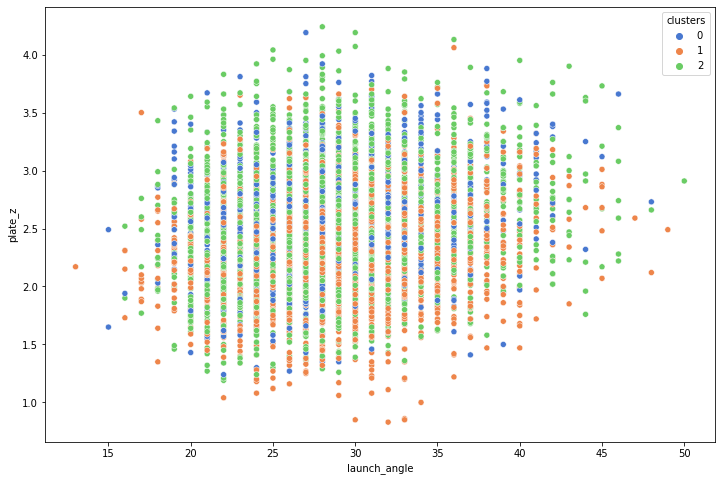

In [27]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df2, y='plate_z', x='launch_angle', hue='clusters', palette='muted')
plt.show()

This scatterplot compares <strong>height of the ball when it crosses the plate</strong> (in feet) and the <strong>launch angle of the ball off the bat</strong>. There is no order to the clustering.

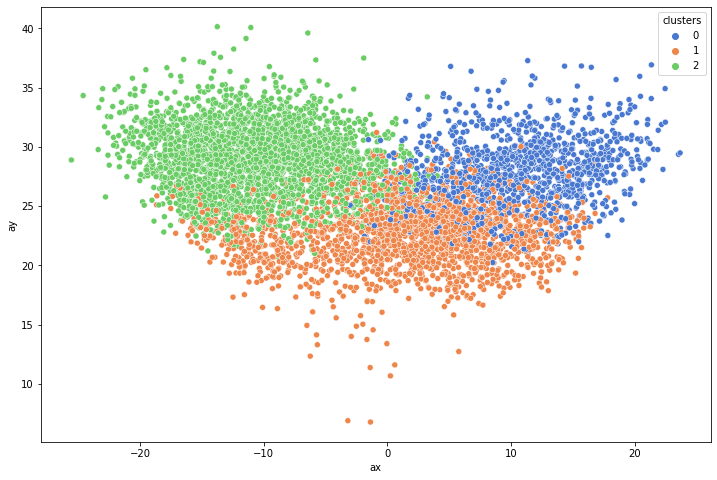

In [28]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df2, x='ax', y='ay', hue='clusters', palette='muted')
plt.show()

This scatterplot compares <strong>acceleration of the pitch in the horizontal (x) dimension </strong> (in feet/second/second) and the <strong>acceleration of the pitch in the front-to-back (y) dimension</strong> (the plane extending from the pitcher to the catcher in ft/second/second). Again, we see a noticable gap when ax is close to zero. What isn't taken into account here is the handedness of the pitchers, which would influence the ax significantly depending on which side of the body the ball was being released.

In [48]:
df2.groupby('clusters').agg({'release_speed':['mean', 'median'],
                            'pfx_x':['mean', 'median'],
                            'pfx_z':['mean', 'median'],
                            'plate_x':['mean', 'median'],
                            'plate_z':['mean', 'median'],
                            'vx0':['mean', 'median'],
                            'vy0':['mean', 'median'],
                            'vz0':['mean', 'median'],
                            'ax':['mean', 'median'],
                            'ay':['mean', 'median'],
                            'az':['mean', 'median'],
                            'hit_distance_sc':['mean', 'median'],
                            'launch_speed':['mean', 'median'],
                            'launch_angle':['mean', 'median']}).transpose()

clusters                         0           1           2
release_speed   mean     91.373680   82.639813   92.923590
                median   91.700000   83.400000   93.300000
pfx_x           mean      0.770775    0.167653   -0.746330
                median    0.780000    0.270000   -0.750000
pfx_z           mean      1.160204    0.075953    1.161791
                median    1.220000    0.150000    1.240000
plate_x         mean      0.008978    0.015602   -0.020857
                median    0.020000    0.020000   -0.020000
plate_z         mean      2.553143    2.328553    2.559055
                median    2.550000    2.320000    2.540000
vx0             mean     -6.192973    1.336184    6.111612
                median   -6.431878    2.499011    6.096865
vy0             mean   -132.856323 -120.317667 -135.133939
                median -133.390376 -121.386507 -135.651557
vz0             mean     -5.214957   -1.611593   -5.331305
                median   -5.252695   -1.854400   -5.300277
ax              mean     10.448715    1.338170  -10.455072
                median   10.731940    2.119676  -10.598422
ay              mean     27.951701   22.742035   28.982470
                median   27.915047   22.852537   29.028348
az              mean    -17.423884  -31.146204  -16.874722
                median  -16.637852  -30.350326  -15.845472
hit_distance_sc mean    403.482964  399.034192  401.226753
                median  405.000000  399.000000  402.000000
launch_speed    mean    105.096337  103.623934  104.801143
                median  105.300000  103.800000  104.900000
launch_angle    mean     28.333901   28.984543   28.663110
                median   28.000000   29.000000   28.000000

## 6. K-means part II

The above clustering looked at all homeruns, while interesting and important, I feel it is too broad and lumping many different pitchers and hitters all into the same data set. In this next section, the same clustering will be done, but zeroing in on just one hitter: <strong>J.P. Crawford </strong>of the Seattle Mariners.

In [30]:
# subset for just the home runs

jp = df[columns].loc[df['player_name'] == 'Crawford, J.P.']

In [31]:
jp.shape

(510, 14)

In [32]:
# check for missing values

jp.isnull().sum()

release_speed      0
pfx_x              0
pfx_z              0
plate_x            0
plate_z            0
vx0                0
vy0                0
vz0                0
ax                 0
ay                 0
az                 0
hit_distance_sc    2
launch_speed       2
launch_angle       2
dtype: int64

In [33]:
jp = jp.loc[jp['launch_angle'].isnull() == False]

In [34]:
# scale the data set

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(jp), columns=columns)
df_scaled.head()

,release_speed,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,hit_distance_sc,launch_speed,launch_angle
0,-0.482385,0.294069,-0.190826,-1.216340,-0.506218,-1.468925,0.498903,0.485648,0.437872,-0.202436,-0.347368,0.474319,-0.030468,0.052970
1,-1.702617,1.604584,-1.569728,-0.102019,-0.524336,0.072980,1.697995,1.135778,1.183796,-0.496771,-1.517876,0.426005,-0.254784,0.229535
2,0.989072,-0.036408,1.130621,1.110049,0.852590,0.991399,-0.976029,-0.652677,-0.167137,1.228921,1.254820,-1.047546,-1.016098,-0.653291
3,1.222352,-0.366886,1.460983,1.598786,-0.397514,1.364972,-1.178874,-1.479772,-0.570550,1.592567,1.732540,0.103918,-1.865779,1.394864
4,-1.702617,-1.221569,-1.383002,-0.121569,-1.484560,-0.852483,1.718460,1.503657,-0.726444,-0.413292,-1.405663,1.537208,0.343391,0.547352


In [35]:
# Defines the range of potential clusters in the data.

num_cl = range(1, 10) 

# Defines k-means clusters in the range assigned above.

kmeans = [KMeans(n_clusters=i) for i in num_cl] 

In [36]:
# create a score that represents a rate of variation for each given cluster option

score = [kmeans[i].fit(df_scaled).score(df_scaled) for i in range(len(kmeans))]
score

[-7112.0,
 -5248.547077300761,
 -4279.188335262728,
 -3933.8361033889246,
 -3678.946359876996,
 -3461.747226373429,
 -3282.886830769742,
 -3151.0856977495296,
 -2999.42807577141]

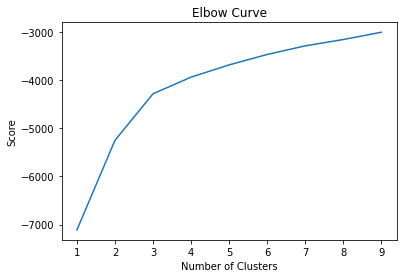

In [37]:
# plot the graph for the elbow technique

plt.plot(num_cl, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [38]:
kmeans = KMeans(n_clusters = 3) 
kmeans.fit(df_scaled)

KMeans(n_clusters=3)

In [39]:
df_scaled['clusters'] = kmeans.fit_predict(jp)
jp['clusters'] = kmeans.fit_predict(jp)

In [40]:
jp['clusters'].value_counts()

0    221
1    147
2    140
Name: clusters, dtype: int64

In [41]:
jp_hits = df.loc[df['player_name'] == 'Crawford, J.P.']
hits = ['single', 'double', 'triple', 'home_run']
hue_hits = jp_hits['events'].isin(hits)

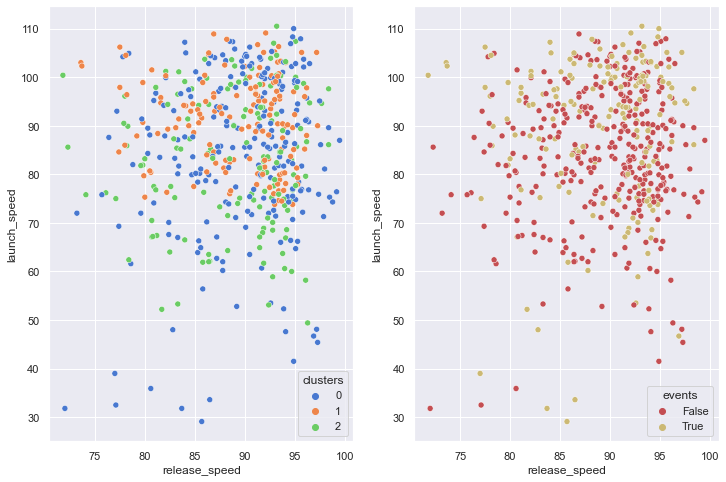

In [42]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

sns.scatterplot(data=jp, x='release_speed', y='launch_speed', hue='clusters', palette='muted', ax=axes[0])
sns.scatterplot(data=jp, x='release_speed', y='launch_speed', hue=hue_hits, palette=['r','y'], ax=axes[1])
plt.show()

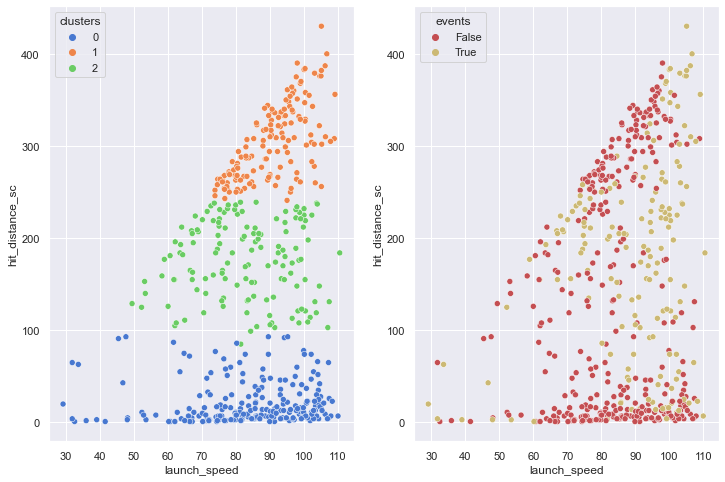

In [43]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

sns.scatterplot(data=jp, x='launch_speed', y='hit_distance_sc', hue='clusters', palette='muted', ax=axes[0])
sns.scatterplot(data=jp, x='launch_speed', y='hit_distance_sc', hue=hue_hits, palette=['r','y'], ax=axes[1])
plt.show()

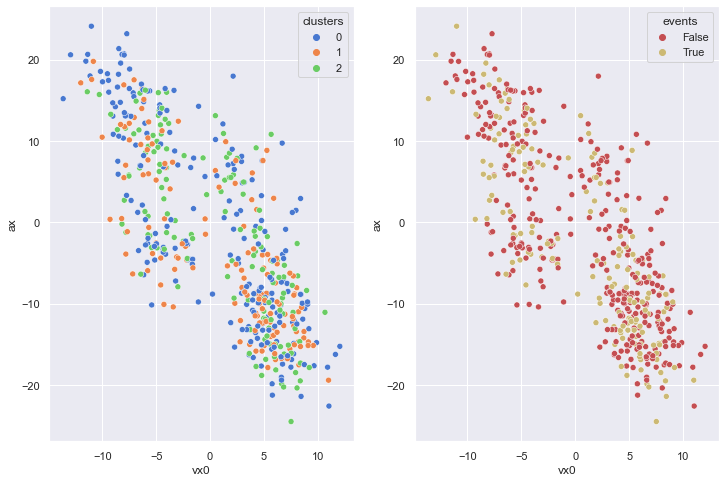

In [44]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

sns.scatterplot(data=jp,  x='vx0', y='ax', hue='clusters', palette='muted', ax=axes[0])
sns.scatterplot(data=jp,  x='vx0', y='ax', hue=hue_hits, palette=['r','y'], ax=axes[1])
plt.show()

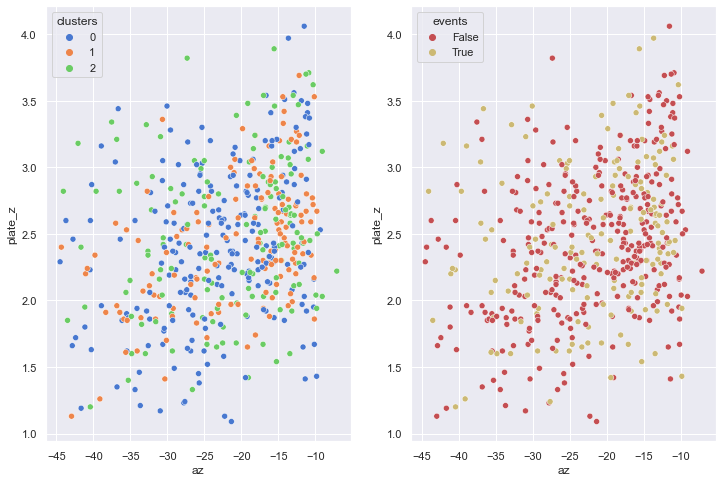

In [45]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

sns.scatterplot(data=jp, x='az', y='plate_z', hue='clusters', palette='muted', ax=axes[0])
sns.scatterplot(data=jp, x='az', y='plate_z', hue=hue_hits, palette=['r','y'], ax=axes[1])
plt.show()

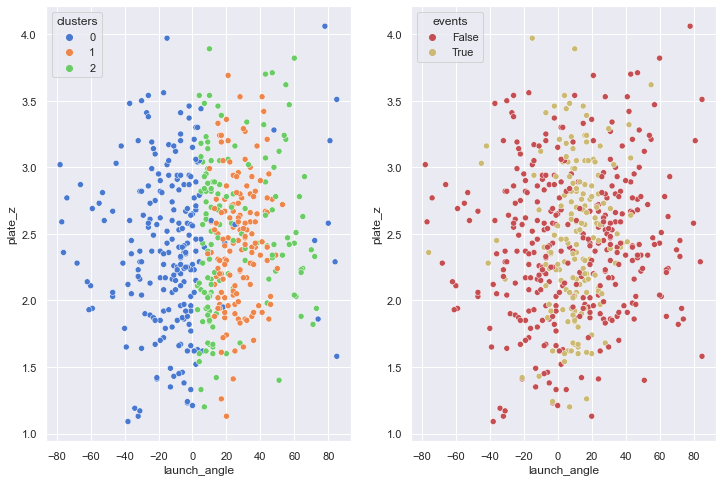

In [46]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

sns.scatterplot(data=jp, x='launch_angle', y='plate_z', hue='clusters', palette='muted', ax=axes[0])
sns.scatterplot(data=jp, x='launch_angle', y='plate_z', hue=hue_hits, palette=['r','y'], ax=axes[1])
plt.show()

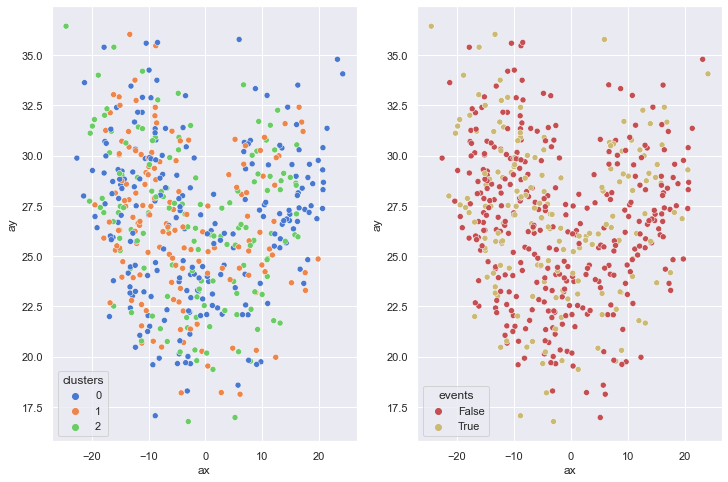

In [47]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

sns.scatterplot(data=jp, x='ax', y='ay', hue='clusters', palette='muted', ax=axes[0])
sns.scatterplot(data=jp, x='ax', y='ay', hue=hue_hits, palette=['r','y'], ax=axes[1])
plt.show()

I used the same scatter plots as in the above k-means clustering for the home runs, but I applied them to balls hit in play by J.P. Crawford. In addition, I color coded the same scatter plot with hits vs. no hits. This was to see if the clustering algorithm could identify hits. It didn't seem to yield the results I was hoping, but there are more ways to subset and run this clustering algoritm.